# Painting Classifier by Style

## Imports

In [11]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import PIL
pd.options.mode.chained_assignment = None  # default='warn'

from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, RandomFlip, RandomZoom, RandomRotation
from keras.utils import to_categorical
from keras.applications.resnet_v2 import ResNet50V2


## Loading in the data

In [12]:
df = pd.read_csv("all_data_info.csv")
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


## Visualizing some of the art 

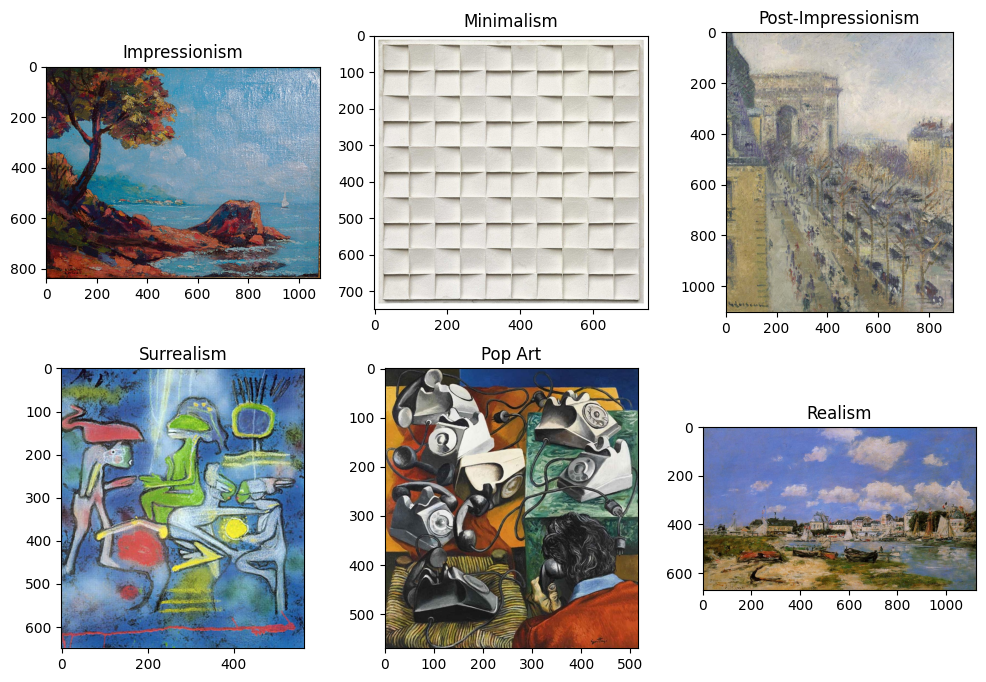

In [13]:
train_1_folder = "/Users/aryan/Desktop/train_3"

# create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the first 6 images
for i in range(6):
    # get the image path and read the image
    img_name = os.listdir(train_1_folder)[i]
    img_path = os.path.join(train_1_folder, img_name)
    img = plt.imread(img_path)
    
    # find the corresponding row in the DataFrame
    row = df[df["new_filename"] == img_name].iloc[0]
    
    # get the artist, title, and style information
    artist = row["artist"]
    title = row["title"]
    style = row["style"]
    
    # plot the image in the appropriate subplot
    row_index, col_index = divmod(i, 3)
    axs[row_index, col_index].imshow(img)
    axs[row_index, col_index].set_title(style)

# show the figure
plt.show()

## Preprocessing

It is evident we have a ton of data to work with. Let's take a deeper look into the Style column since we will be working with it extensively.

In [14]:
df["style"].value_counts()

Impressionism               10643
Realism                     10523
Romanticism                  9285
Expressionism                7013
Post-Impressionism           5778
                            ...  
Spectralism                     5
Kinetic Art                     3
Ilkhanid                        2
Renaissance                     1
Environmental (Land) Art        1
Name: style, Length: 136, dtype: int64

There is a huge imbalance in the data here. We have 5 instances of artworks that fall under the spectralism category and have more than 10,000 impressionism style paintings. We would be naive to train our model on the dataset as is. We need to filter out styles that do not have enough samples and also those that have too many. Here, the choice for the threshold is really arbitrary and we decided to work with art styles with 2,000 samples. This means that styles like realism with several thousands of paintings need to be cut down to as close to 2,000 as possible.

Text(0.5, 0, 'Number of paintings')

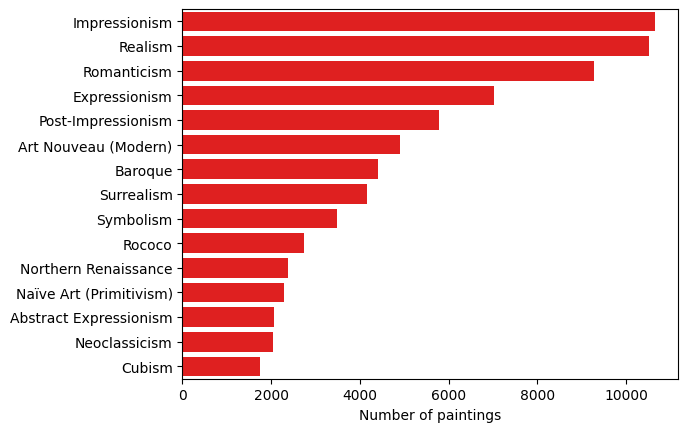

In [15]:
df["style"].value_counts()[:15]

sns.barplot(x=df["style"].value_counts()[:15].values, y=df["style"].value_counts()[:15].index,
            color="r")
plt.xlabel("Number of paintings")

Looking at the 15 most populated styles in our dataset, we see that Neoclassicism is just above our threshold with 2,038 samples. So, the next step is to cut down all samples above our threshold to meet our requirements for an unbiased dataset. To do this we will create a function to loop over the overpopulated styles, find the difference between them and the count for our Neoclassicism style, and reduce it to match our minimum limit.

In [16]:
overpop_styles = df["style"].value_counts()[:14].index.tolist()
overpop_styles

['Impressionism',
 'Realism',
 'Romanticism',
 'Expressionism',
 'Post-Impressionism',
 'Art Nouveau (Modern)',
 'Baroque',
 'Surrealism',
 'Symbolism',
 'Rococo',
 'Northern Renaissance',
 'Naïve Art (Primitivism)',
 'Abstract Expressionism',
 'Neoclassicism']

In [17]:
def style_balancer(style_arr, df):
    """
    Reduce the number of samples for each overpopulated style in the given DataFrame to match the count of the
    least represented style, and return a new DataFrame with the reduced number of samples for each style.

    Parameters:
        style_arr (list of str): A list of style names to balance.
        df (pandas.DataFrame): The DataFrame containing the samples to balance.

    Returns:
        pandas.DataFrame: A new DataFrame with the reduced number of samples for each style.

    Raises:
        None

    """

    # Get the minimum number of samples for any style in the DataFrame
    min_val = df["style"].value_counts()[13] # assuming "Neoclassicism" is at index 13

    # Initialize an empty DataFrame variable to hold the balanced samples for all styles
    empty_df_var = None

    # Loop through each style in the style_arr list
    for _style in style_arr:
        # Create a boolean mask to select only the samples with the current style
        style_mask = df["style"] == _style

        # Create a new DataFrame with only the samples with the current style
        style_df = df[style_mask]

        # Calculate the total number of samples for the current style
        tot = len(style_df.index)

        # Calculate the number of samples to remove to match the minimum count
        rmv = tot - min_val

        # Remove the excess samples from the current style DataFrame
        style_df.drop(style_df.index[range(rmv)], inplace=True)

        # Concatenate the current style DataFrame to the empty_df_var DataFrame to add it to the new DataFrame
        fin_df = pd.concat([empty_df_var, style_df], ignore_index=True)

        # Update the empty_df_var DataFrame with the new DataFrame containing the current style
        empty_df_var = fin_df

    # Return the final DataFrame containing the balanced samples for all styles
    return fin_df


df = style_balancer(overpop_styles, df)
df["style"].value_counts()


Impressionism              2038
Realism                    2038
Romanticism                2038
Expressionism              2038
Post-Impressionism         2038
Art Nouveau (Modern)       2038
Baroque                    2038
Surrealism                 2038
Symbolism                  2038
Rococo                     2038
Northern Renaissance       2038
Naïve Art (Primitivism)    2038
Abstract Expressionism     2038
Neoclassicism              2038
Name: style, dtype: int64

In [18]:
def style_returner(img_name):
    for i in range(len(df)):
        if img_name == df.loc[i, "new_filename"]:
            return df.loc[i, "style"]
        
style_returner('1165.jpg')

'Impressionism'

## Shuffle data

In [19]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

df["in_train"].value_counts()
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Victor Pasmore,1975.0,abstract,640.0,431.0,69626.0,wikiart,Abstract Expressionism,Grey Symphony,test_only,False,98092.jpg
1,Edouard Manet,1880,portrait,565.0,724.0,34533.0,wikiart,Impressionism,Mother in the Garden at Bellevue,train_and_test,True,5833.jpg
2,Aleksandra Ekster,1916.0,design,597.0,700.0,48234.0,wikiart,Art Nouveau (Modern),"Costume Design for the play ""Famira Kifared"" b...",train_only,True,17333.jpg
3,Esteban Vicente,1996,abstract,492.0,406.0,43773.0,wikiart,Abstract Expressionism,Red Across,train_and_test,False,48939.jpg
4,Howard Pyle,NaN,illustration,578.0,600.0,110621.0,wikipedia,Romanticism,The Merry Adventures of Robin Hood 5,train_and_test,True,9852.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
28527,Paul Gauguin,1875,cityscape,741.0,528.0,23702.0,wikiart,Impressionism,The Seine at the Pont d'Iena,train_and_test,True,19852.jpg
28528,Adriaen van Ostade,1660,genre painting,619.0,721.0,23387.0,wikiart,Baroque,In the Village Inn,train_and_test,True,89381.jpg
28529,Francisco de Zurbaran,NaN,religious painting,357.0,632.0,34893.0,wikipedia,Baroque,Virgin of the Rosary,test_only,False,101284.jpg
28530,Alexander Liberman,1975,abstract,640.0,403.0,279661.0,wikiart,Abstract Expressionism,Untitled Abstract,train_only,True,15544.jpg


## Prepare data for training

In [20]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000

# Loop through each file in the training folder and remove corrupted images from the training set dataframe
for filename in os.listdir(train_1_folder):
    try:
        img = Image.open(os.path.join(train_1_folder, filename))
        img.verify()
    except (IOError, SyntaxError) as e:
        print('Bad file:', filename, e)
        train_df = train_df[train_df['new_filename'] != filename] # Remove the corrupted image from the training set dataframe



In [21]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define data generators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow_from_dataframe generator for the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

Found 3748 validated image filenames belonging to 14 classes.
Found 924 validated image filenames belonging to 14 classes.


/opt/homebrew/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 19077 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4783 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


## Number of samples for each class in training set

In [22]:
class_indices = train_generator.class_indices
classes = train_generator.classes

newd = {key: 0 for key in class_indices}

for i in classes:
    for j, k in class_indices.items():
        if i == k:
            newd[j] += 1

newd

{'Abstract Expressionism': 272,
 'Art Nouveau (Modern)': 288,
 'Baroque': 240,
 'Expressionism': 258,
 'Impressionism': 284,
 'Naïve Art (Primitivism)': 270,
 'Neoclassicism': 277,
 'Northern Renaissance': 279,
 'Post-Impressionism': 283,
 'Realism': 266,
 'Rococo': 255,
 'Romanticism': 272,
 'Surrealism': 248,
 'Symbolism': 256}

## Number of samples for each class in testing set

In [23]:
class_indices = test_generator.class_indices
classes = test_generator.classes

newd = {key: 0 for key in class_indices}

for i in classes:
    for j, k in class_indices.items():
        if i == k:
            newd[j] += 1

newd

{'Abstract Expressionism': 57,
 'Art Nouveau (Modern)': 72,
 'Baroque': 73,
 'Expressionism': 67,
 'Impressionism': 69,
 'Naïve Art (Primitivism)': 70,
 'Neoclassicism': 75,
 'Northern Renaissance': 75,
 'Post-Impressionism': 54,
 'Realism': 55,
 'Rococo': 72,
 'Romanticism': 64,
 'Surrealism': 52,
 'Symbolism': 69}

## Model architecture

In [24]:
# define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)),
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(14, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

## Train model

In [25]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

Epoch 1/10


2023-04-24 18:05:07.006148: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


118/118 [==============================] - 86s 726ms/step - loss: 2.7472 - accuracy: 0.0840 - val_loss: 2.6766 - val_accuracy: 0.0887
Epoch 2/10
118/118 [==============================] - 86s 720ms/step - loss: 2.5911 - accuracy: 0.1107 - val_loss: 2.6226 - val_accuracy: 0.1299
Epoch 3/10
118/118 [==============================] - 85s 715ms/step - loss: 2.5143 - accuracy: 0.1363 - val_loss: 2.4796 - val_accuracy: 0.1591
Epoch 4/10
118/118 [==============================] - 83s 699ms/step - loss: 2.4612 - accuracy: 0.1692 - val_loss: 2.5417 - val_accuracy: 0.1797
Epoch 5/10
118/118 [==============================] - 83s 697ms/step - loss: 2.4264 - accuracy: 0.1758 - val_loss: 2.4264 - val_accuracy: 0.1948
Epoch 6/10
118/118 [==============================] - 83s 698ms/step - loss: 2.3807 - accuracy: 0.2012 - val_loss: 2.4759 - val_accuracy: 0.1732
Epoch 7/10
118/118 [==============================] - 87s 732ms/step - loss: 2.3549 - accuracy: 0.2081 - val_loss: 2.3476 - val_accuracy: 0.2

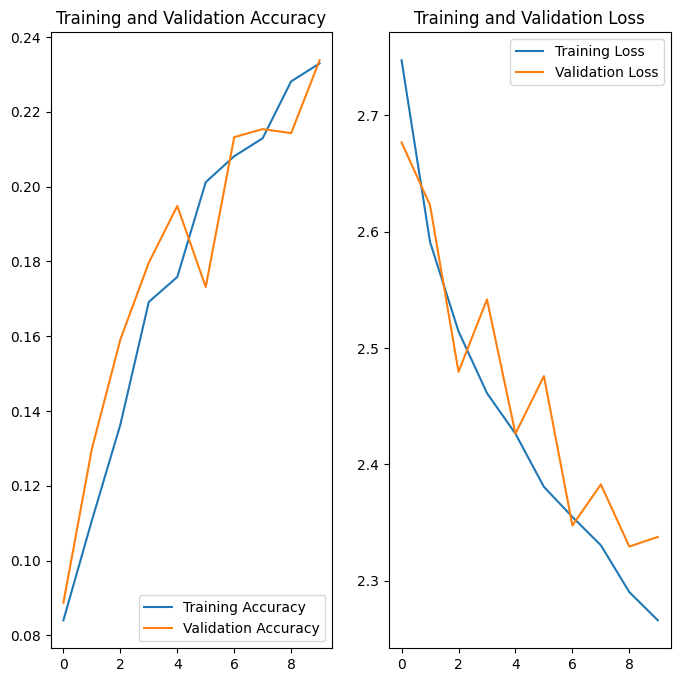

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

29/29 [==============================] - 10s 357ms/step


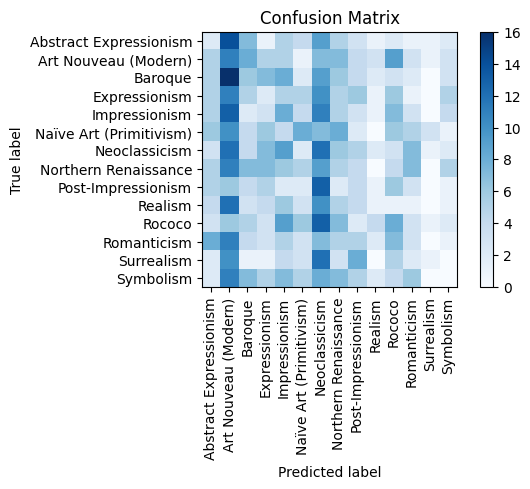

In [27]:
# Get the true labels and predicted labels for the test data
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## ResNet model 

In [28]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(14, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [29]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))

# Print the accuracy
print("Accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
118/118 [==============================] - 129s 1s/step - loss: 2.5068 - accuracy: 0.1809 - val_loss: 2.1977 - val_accuracy: 0.2662
Epoch 2/10
118/118 [==============================] - 126s 1s/step - loss: 2.1596 - accuracy: 0.2767 - val_loss: 1.9810 - val_accuracy: 0.3474
Epoch 3/10
118/118 [==============================] - 129s 1s/step - loss: 2.0229 - accuracy: 0.3159 - val_loss: 1.8885 - val_accuracy: 0.3593
Epoch 4/10
118/118 [==============================] - 132s 1s/step - loss: 1.8869 - accuracy: 0.3709 - val_loss: 1.8524 - val_accuracy: 0.3885
Epoch 5/10
118/118 [==============================] - 133s 1s/step - loss: 1.8110 - accuracy: 0.3930 - val_loss: 1.8319 - val_accuracy: 0.3939
Epoch 6/10
118/118 [==============================] - 1048s 9s/step - loss: 1.7352 - accuracy: 0.4133 - val_loss: 1.8311 - val_accuracy: 0.3723
Epoch 7/10
118/118 [==============================] - 266s 2s/step - loss: 1.7042 - accuracy: 0.4248 - val_loss: 1.7862 - val_accuracy: 0.400

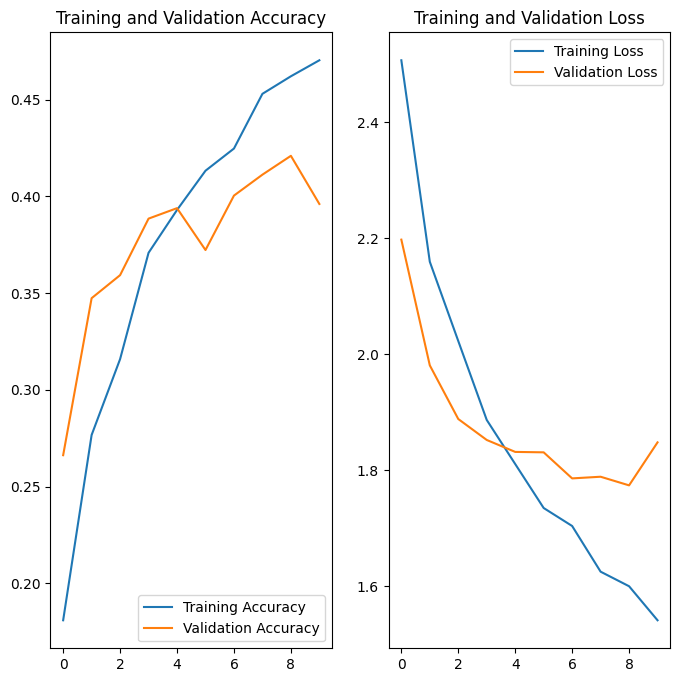

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

29/29 [==============================] - 26s 871ms/step


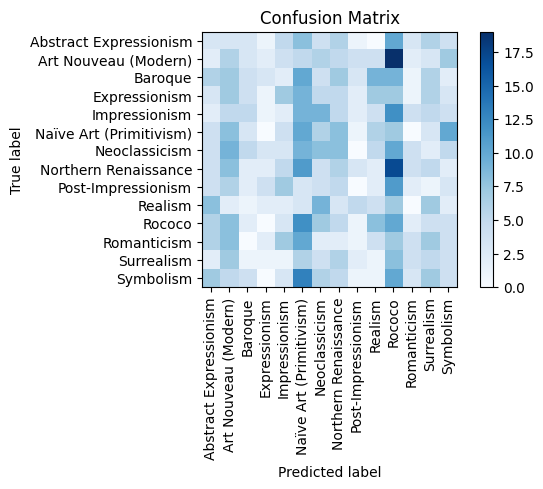

In [31]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()